<a href="https://colab.research.google.com/github/VolkhinD/stroke_prediction/blob/main/predict_stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Work with Unbalanced Data to predict Stroke

**Summary**


In this notebook I'm going to investigate all technics that are useful for Unbalanced Data. I took most of information [here](https://imbalanced-learn.org/stable/index.html), in wonderful module Imbalanced-Learn

![](https://imbalanced-learn.org/stable/_static/logo_wide.png)

# Preparation

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#models
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.svm import SVC

# DATA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector as selector
from  imblearn.over_sampling import RandomOverSampler, SMOTENC, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn import FunctionSampler


from imblearn.pipeline import make_pipeline # the number of samples can vary during training


#metrics
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score, recall_score
from imblearn.metrics import classification_report_imbalanced



In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
path = '/content/drive/MyDrive/Data/healthcare-dataset-stroke-data.csv'

data = pd.read_csv(path)

In [13]:
data.shape

(5110, 12)

# Work with Data

* Delete one row where gender = "Other", 
* Delete "id" column since it doesn't give an information

In [14]:
data.drop(data[data['gender']=='Other'].index,inplace=True)
data = data.drop('id', axis=1)

In [15]:
data.loc[data['stroke'] == 1].sort_values(by='age')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
182,Female,32.00,0,0,Yes,Private,Rural,76.13,29.9,smokes,1
118,Female,38.00,0,0,No,Self-employed,Urban,82.28,24.0,formerly smoked,1
133,Female,38.00,0,0,Yes,Private,Rural,101.45,NaN,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
42,Male,82.00,0,1,Yes,Private,Urban,144.90,26.4,smokes,1
56,Female,82.00,0,0,Yes,Private,Rural,59.32,33.2,never smoked,1
188,Male,82.00,0,0,Yes,Private,Rural,86.62,29.5,formerly smoked,1
23,Male,82.00,0,1,Yes,Private,Rural,208.30,32.5,Unknown,1


* There are 3 persons who are 1 and 14 and 32 years old and nothing in Data point directly to cause of their stroke.
* I consider them as outliers. 

In [16]:
data = data.drop(labels=[162, 245, 182], axis=0)

Also, the first stroke was in age 38, let's find out how many persons, younger than 38, datset contains

In [17]:
children = data.loc[data['age'] < 38]
print(f'There are {children.shape[0]} !!!! young persons in Dataset and all of them does not have a stroke')
persent = round((children.shape[0]*100/data.shape[0]), 2)
print(f'This is {persent} % of whole Dataset')

There are 2023 !!!! young persons in Dataset and all of them does not have a stroke
This is 39.62 % of whole Dataset


 * There is some technique called "Under-sampling" which we can not afford this time since out Dataset has not enough data to perform it.
 * But in this case it's worth to get rid of half of 'children' data since it's not super informative.

In [18]:
import random 
a = np.array(children.index)
del_i = pd.Series(np.random.choice(a, size=700))
data = data.drop(del_i)


Take a look to some graphs

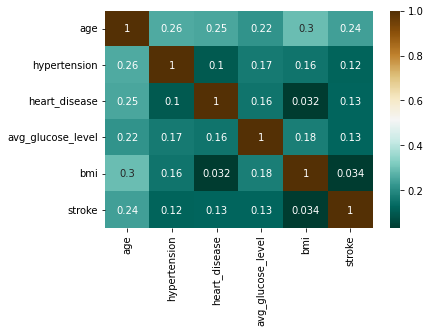

In [19]:
sns.heatmap(data.corr(), cmap = 'BrBG_r',annot=True)

* Age positivly correlates with 'hypertension', 'heart desease',  'avg_glucose_level' and 'bmi'. 
* So all of them tends to increase with an increase in age.

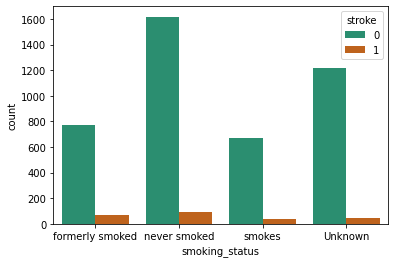

In [20]:
sns.countplot(x= 'smoking_status', data = data, hue='stroke', palette="Dark2")

* To test a model's perfomance I will be using cross validation. 
* Before starting work with models, save holdout dataset to evaluate the best models perfomance. 
* To make sure train and holdout datasets have same ratio, set parameter stratify.

In [21]:
data, data_holdout = train_test_split(data, test_size=0.15, random_state=0, stratify=data.stroke)

In [22]:
y = data.stroke
features = list(data.columns)[:-1]
data = pd.DataFrame(data[features])

In [23]:
y_holdout = data_holdout.stroke
data_holdout = pd.DataFrame(data_holdout[features])

In [24]:
print(data.shape[0])
print(data_holdout.shape[0])

3847
679


In [47]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
dtype: object

# Preprocesing

In [60]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True),StandardScaler(), )
t_lin = [('num', num_pipe, [1, 2, 3, 7, 8]), ('cat', OneHotEncoder(), [0, 4, 5, 6, 9])]
preprocessor_linear = ColumnTransformer(transformers=t_lin)


t_tree = [('num', SimpleImputer(strategy="mean", add_indicator=True), [1, 2, 3, 7, 8]), 
          ('cat', OrdinalEncoder(), [0, 4, 5, 6, 9])]
preprocessor_tree = ColumnTransformer(transformers=t_tree)
    

Choose Balance Accuracy and Recall as a score (might be F2 instead of Recall) not to miss many True Positive predictions

In [61]:
index = []
scores = {"balanced_accuracy": [], 'recall': []}
scoring = ["balanced_accuracy", 'recall']
models = {}

# Basic Models

In [62]:
lr_clf = make_pipeline(preprocessor_linear, LogisticRegression(max_iter=1000))
index += ["Logistic regression"]
cv_result = cross_validate(lr_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286


In [63]:
rf_clf = make_pipeline(
    preprocessor_tree, RandomForestClassifier(random_state=42))
cv_result = cross_validate(rf_clf, data, y, scoring=scoring, cv=10)
index += ["Random forest"]
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095


Random Forest Perform better than Logistic Regression

In [64]:
svc_cls = make_pipeline(preprocessor_linear, SVC(kernel='linear', C=1))
index += ["C-Support Vector Classification"]
cv_result = cross_validate(svc_cls, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000


The worst perfomance for now

# Use Class [Weight](https://imbalanced-learn.org/stable/auto_examples/applications/plot_impact_imbalanced_classes.html#use-class-weight)

In [65]:
""" class_weight="balanced" such that the weight applied is inversely proportional to the class frequency."""
lr_clf.set_params(logisticregression__class_weight="balanced")

index += ["Logistic regression with balanced class weights"]
models["Logistic regression with balanced class weights"] = lr_clf
cv_result = cross_validate(lr_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762


In [66]:
rf_clf.set_params(randomforestclassifier__class_weight="balanced")
index += ["Random forest with balanced class weights"]
cv_result = cross_validate(rf_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333


Random Forest was not significantly improved like Logistic Regression and SVM

In [67]:
svc_cls.set_params(svc__class_weight='balanced')
index += ["C-Support Vector Classification with balanced class weights"]
models["C-Support Vector Classification with balanced class weights"] = svc_cls
cv_result = cross_validate(svc_cls, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524


**Conclusion:**\
Linear models works with class_weight much better than Random Forest

# Use [Special](https://imbalanced-learn.org/stable/ensemble.html#) Algorithms in Imblearn

In [68]:
bal_rf_clf = make_pipeline(
    preprocessor_tree,
    BalancedRandomForestClassifier(random_state=42, n_jobs=2),)
index += ["Balanced random forest"]
models["Balanced random forest"] = bal_rf_clf
cv_result = cross_validate(bal_rf_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524
Balanced random forest,0.748377,0.789762


In [69]:
rusboost = make_pipeline(
    preprocessor_tree,
    RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0))
index += ["Balanced Boosting"]
cv_result = cross_validate(rusboost, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores




,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524
Balanced random forest,0.748377,0.789762
Balanced Boosting,0.655974,0.516429


# Change Data by adding or deleting some data

## Under Sampling

In [70]:
from imblearn.under_sampling import RandomUnderSampler
un_lr_clf = make_pipeline(
    preprocessor_linear,
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000),)
index += ["Under-sampling + Logistic regression"]
models["Under-sampling + Logistic regression"] = un_lr_clf
cv_result = cross_validate(un_lr_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524
Balanced random forest,0.748377,0.789762
Balanced Boosting,0.655974,0.516429
Under-sampling + Logistic regression,0.754946,0.799048


In [71]:
rf_clf = make_pipeline(
    preprocessor_tree,
    RandomUnderSampler(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2),)
index += ["Under-sampling + Random forest"]
cv_result = cross_validate(rf_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524
Balanced random forest,0.748377,0.789762
Balanced Boosting,0.655974,0.516429
Under-sampling + Logistic regression,0.754946,0.799048
Under-sampling + Random forest,0.731410,0.799524


##Combination of over- and under-sampling

In [72]:
enn_lr_clf = make_pipeline(
    preprocessor_linear,
    SMOTEENN(random_state=0),
    LogisticRegression(max_iter=1000),)
index += ["Over-sampling SMOTE and cleaning ENN. + Logistic regression"]
models["Over-sampling SMOTE and cleaning ENN. + Logistic regression"] = enn_lr_clf
cv_result = cross_validate(un_lr_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524
Balanced random forest,0.748377,0.789762
Balanced Boosting,0.655974,0.516429
Under-sampling + Logistic regression,0.754946,0.799048
Under-sampling + Random forest,0.731410,0.799524


In [73]:
enn_rf_clf = make_pipeline(
    preprocessor_tree,
    SMOTEENN(random_state=0),
    RandomForestClassifier(random_state=42, n_jobs=2),)
index += ["Over-sampling SMOTE and cleaning ENN + Random forest"]
cv_result = cross_validate(rf_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524
Balanced random forest,0.748377,0.789762
Balanced Boosting,0.655974,0.516429
Under-sampling + Logistic regression,0.754946,0.799048
Under-sampling + Random forest,0.731410,0.799524


In [74]:
tomek_lr_clf = make_pipeline(
    preprocessor_linear,
    SMOTETomek(random_state=0),
    LogisticRegression(max_iter=1000),)
index += ["Over-sampling SMOTE and cleaning Tomek links + Logistic regression"]
models["Over-sampling SMOTE and cleaning Tomek links + Logistic regression"] = tomek_lr_clf
cv_result = cross_validate(un_lr_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524
Balanced random forest,0.748377,0.789762
Balanced Boosting,0.655974,0.516429
Under-sampling + Logistic regression,0.754946,0.799048
Under-sampling + Random forest,0.731410,0.799524


In [75]:
tomek_rf_clf = make_pipeline(
    preprocessor_tree,
    SMOTETomek(random_state=0),
    RandomForestClassifier(random_state=42, n_jobs=2),)
index += ["Over-sampling SMOTE and cleaning  Tomek links + Random forest"]
cv_result = cross_validate(rf_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524
Balanced random forest,0.748377,0.789762
Balanced Boosting,0.655974,0.516429
Under-sampling + Logistic regression,0.754946,0.799048
Under-sampling + Random forest,0.731410,0.799524


## All Oversampling Methods

In [76]:
cat_indexes = [data.columns.get_loc(col) for col in data.columns if data[col].dtype == 'object']
all_methods = {"SMOTE": SMOTE(random_state=0, sampling_strategy='minority'),
               "ADASYN": ADASYN(random_state=0),
               'BorderlineSMOTE-1': BorderlineSMOTE(random_state=0, kind="borderline-1"),
               'BorderlineSMOTE-2': BorderlineSMOTE(random_state=0, kind="borderline-2"),
               'SVMSMOTE': SVMSMOTE(random_state=0),
               'RandomOverSampler': RandomOverSampler(random_state=0),}


for key, method in all_methods.items(): 
    if key in ['RandomOverSampler']:
        model = make_pipeline(preprocessor_tree, method, GradientBoostingClassifier(random_state=0))
        index += [f'Gradient Boosting and {key}']
    else:
        model = make_pipeline(preprocessor_linear, method, LogisticRegression(max_iter=1000))
        index += [f'Logistic Regression and {key}']
  
    
    cv_result = cross_validate(model, data, y, scoring=scoring, cv=10)
    scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
    scores['recall'].append(cv_result['test_recall'].mean())
    df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.506181,0.014286
Random forest,0.520447,0.043095
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.758652,0.784762
Random forest with balanced class weights,0.515704,0.033333
C-Support Vector Classification with balanced class weights,0.756499,0.789524
Balanced random forest,0.748377,0.789762
Balanced Boosting,0.655974,0.516429
Under-sampling + Logistic regression,0.754946,0.799048
Under-sampling + Random forest,0.731410,0.799524


In [42]:
lr_border = make_pipeline(preprocessor_linear, BorderlineSMOTE(random_state=0, kind="borderline-2"), LogisticRegression(max_iter=1000, random_state=2))
lr_svm_smote = make_pipeline(preprocessor_linear, SVMSMOTE(random_state=0), LogisticRegression(max_iter=1000, random_state=2)) # gives the best presition
lr_smoteenn = make_pipeline(preprocessor_linear, SMOTEENN(random_state=0), LogisticRegression(max_iter=1000, random_state=2))
lr_smotetomek = make_pipeline(preprocessor_linear, SMOTETomek(random_state=0), LogisticRegression(max_iter=1000, random_state=2))

models['Logistic Regression and BorderlineSMOTE-1'] = lr_border
models['Logistic Regression and SVMSMOTE'] = lr_svm_smote
models['Logistic Regression and SMOTEENN'] = lr_smoteenn
models['Logistic Regression and SMOTETomek'] = lr_smotetomek

# Take a look to the best models

In [43]:
for name, model in models.items():
    print(name)
    model.fit(data, y)
    print(classification_report(y_holdout, model.predict(data_holdout)))
    print('-'*60)

Logistic regression with balanced class weights
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       642
           1       0.16      0.84      0.27        37

    accuracy                           0.75       679
   macro avg       0.57      0.79      0.56       679
weighted avg       0.94      0.75      0.82       679

------------------------------------------------------------
C-Support Vector Classification with balanced class weights
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       642
           1       0.16      0.89      0.27        37

    accuracy                           0.74       679
   macro avg       0.58      0.81      0.55       679
weighted avg       0.95      0.74      0.81       679

------------------------------------------------------------
Balanced random forest
              precision    recall  f1-score   support

           0       0.99      0.71     